In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 显示所有行
pd.set_option('display.max_rows', None)

In [3]:
# df_hs = pd.read_excel("data/上市公司沪市.xls",converters= {u'StockCode':str})
# df_ss = pd.read_excel("data/上市公司深市.xls",converters= {u'StockCode':str})
# df_zxb = pd.read_excel("data/上市公司中小板.xls",converters= {u'StockCode':str})
# df_cyb = pd.read_excel("data/上市公司创业板.xls",converters= {u'StockCode':str})

df_hsA = pd.read_excel("data/沪深A股.xls",converters= {u'StockCode':str})
df_szA = pd.read_excel("data/上证A股.xls",converters= {u'StockCode':str})
df_shenA = pd.read_excel("data/深证A股.xls",converters= {u'StockCode':str})

df_sz50 = pd.read_excel("data/上证50.xls",converters= {u'StockCode':str})
df_hs300 = pd.read_excel("data/沪深300.xls",converters= {u'StockCode':str})
df_zz500 = pd.read_excel("data/中证500.xls",converters= {u'StockCode':str})

In [12]:
# df = pd.concat([df_hs,df_ss])
df = df_shenA

In [13]:
# df.head()

In [14]:
# 处理百分比
def disposePercent(percent):
    index = percent.find('%')
    if index < 0:
        return 0
    else:
        return float(percent[:index])

# 处理数值
def disposeNumeric(numeric):
    if numeric == '-':
        return 0
    else:
        return float(numeric)

def disposeUnit(price):
    price = price.replace('\n','').replace('\t','')
    unit = ['亿元','元','亿股']
    index = -1
    for u in unit:
        index = price.find(u)
        if index >= 0:
            break
    if index < 0:
        return 0
    else:
        return float(price[:index])
    
# 获取行业大类
def getTopTrade(trade):
    if trade == '-':
        return ''
    else:
        trades = trade.split('—')
        return trades[0].strip()
# 获取行业小类
def getSubTrade(trade):
    if trade == '-':
        return ''
    else:
        trades = trade.split('—')
        if len(trades) > 1:
            return trades[1].strip()
        else:
            return ''
    

def getNetProfitRate(np_des):
    np_des = np_des.strip()
    index_rate_s = np_des.find('增长')
    index_rate_e = np_des.find('%')
    
    if index_rate_s != -1:
        return float(np_des[index_rate_s+2:index_rate_e])
    else:
        return 0
    
def disposeNetProfitRate(netProfitRate):
    if netProfitRate == 0:
        return -1
    else:
        return netProfitRate


def disposeScaleShareType(sst):
    return sst.strip()

In [15]:
df['Price'] = df['Price'].apply(lambda x:disposeNumeric(x))

df['PB'] = df['PB'].apply(lambda x:disposePercent(x))

df['PE_S'] = df['PE_S'].apply(lambda x:disposePercent(x))

df['PE_D'] = df['PE_D'].apply(lambda x:disposePercent(x))

df['EarningsPerShare'] = df['EarningsPerShare'].apply(lambda x:disposeUnit(x))

df['NetProfit'] = df['NetProfitDes'].apply(lambda x:disposeUnit(x))

df['NetProfitRate'] = df['NetProfitDes'].apply(lambda x:getNetProfitRate(x))

df['GrossProfitRate'] = df['GrossProfitRate'].apply(lambda x:disposePercent(x))

df['NetAssetValuePerShare'] = df['NetAssetValuePerShare'].apply(lambda x:disposeUnit(x))

df['CapitalStock'] = df['CapitalStock'].apply(lambda x:disposeUnit(x))

df['ScaleShareType'] = df['ScaleShareType'].apply(lambda x:disposeScaleShareType(x))

df = df.drop(['NetProfitDes'],axis=1)

df['ROE'] = df['ROE'].apply(lambda x:disposePercent(x))

# 新建行业大类
df['TopTrade'] = df['Trade'].apply(lambda x:getTopTrade(x))

# 新建行业小类
df['SubTrade'] = df['Trade'].apply(lambda x:getSubTrade(x))

df = df.drop(['Trade'],axis=1)

# 新增市盈率增长率 = 市盈率（PE）/净利润增长率（NetProfitRate）
df['PEG'] = df['PE_S'] / df['NetProfitRate'].apply(lambda x:disposeNetProfitRate(x))

In [16]:
df['PriceLimit'] = df['PriceLimit'].apply(lambda x:disposePercent(x))

df['QuantityRelativeR'] = df['QuantityRelativeR'].apply(lambda x:disposeNumeric(x))

df['TurnoverRate'] = df['TurnoverRate'].apply(lambda x:disposePercent(x))

# 行业分布

In [31]:
s_top = df.groupby(['TopTrade'],as_index=False).size()

In [32]:
s_top = s_top.sort_values(ascending=False)

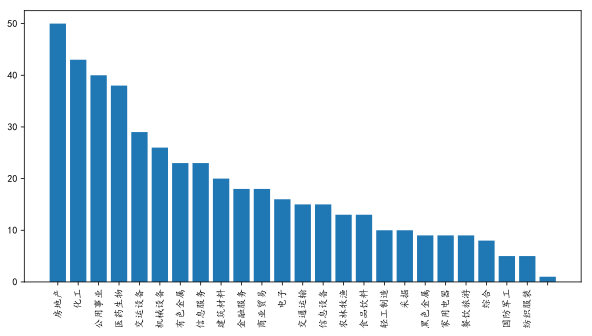

In [33]:
plt.figure(figsize=(10,5))
plt.bar(s_top.keys(),s_top.values)
plt.xticks(rotation=90)
plt.show()

# 市净率分析
## 理论上，市净率越小越好

In [58]:
df_bank = df[df['SubTrade'] == '银行']

df_bank.sort_values(by=['PB'],ascending = True)

# 市盈率增长率（PEG）
## 理论上越小越好

In [65]:
df_peg = df[df['PEG'] > 0]

df_peg[df_peg['TopTrade'] == '机械设备'].sort_values(by=['PEG'],ascending=True).head(10)

# 净资产收益率ROE÷市净率PB
## ROE应选择5%以上的为宜
## 理论上越大越好

In [74]:
df_pb = df[df['PB'] != 0]

df_pb['ROE/PB'] = df_pb['ROE'] / df_pb['PB']

df_pb[df_pb['TopTrade'] == '机械设备'].sort_values(by=['ROE/PB'],ascending=False).head(10)

In [7]:
# 根据指标获取优质股票
def getSuperiorStockByTargets(df,trade,targets,top):
    if len(targets) >= 2:
        code_list = []
        for target in targets:
            df_temp = df.copy()
            if target == 'PEG':
                df_temp = df_temp[df_temp['PEG'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            elif target == 'ROE/PB':
                df_temp = df_temp[df_temp['PB'] != 0]
                df_temp['ROE/PB'] = df_temp['ROE'] / df_temp['PB']
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=False).head(top)
            elif target == 'PB':
                df_temp = df_temp[df_temp['PB'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            elif target == 'PE_D':
                df_temp = df_temp[df_temp['PE_D'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            else:
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            
            code_list.append(list(df_temp['StockCode']))
        both = code_list[0]
        code_list.pop(0)
        while(len(code_list) > 0):
            next_list = code_list[0]
            both = [l for l in both if l in next_list]
            code_list.pop(0)
        return both
    
def getSuperiorStock(df):
    df_gpr = df.copy()
    #毛利率（高，30%~50%）
    df_gpr = df_gpr[df_gpr['GrossProfitRate'] > 30]
    
    #股本（低，小于10亿）
    df_cs = df.copy()
    df_cs = df_gpr[df_gpr['CapitalStock'] < 10]
    
    #净资产收益率（ROE）（高，大于5%）
    df_roe = df.copy()
    df_roe = df_roe[df_roe['ROE'] > 5]
    
    #小盘股
    df_sst = df.copy()
    df_sst = df_sst[df_sst['ScaleShareType'] == '小盘股']
    
    df_list = [df_gpr,df_cs,df_roe,df_sst]
    code_list = []
    for d in df_list:
        code_list.append(list(d['StockCode']))    

    both = code_list[0]
    code_list.pop(0)
    
    while(len(code_list) > 0):
        next_list = code_list[0]
        both = [l for l in both if l in next_list]
        code_list.pop(0)
    return both

In [8]:
# getSuperiorStockByTargets(df,'',['PB','PE_D'],100)

# sl = getSuperiorStock(df)

In [14]:
df_long = df[df['FinanceAnalize'].apply(lambda x:str(x).find('破净股') >= 0) & (df['PE_D'] > 0) & (df['PE_D'] < 15)]

In [15]:
df_long = df_long.sort_values(['PE_D'],ascending=True)

In [9]:
# df.groupby(by=['SubTrade'],as_index=False).size()

In [20]:
# df[(df['FinanceAnalize'].apply(lambda x:str(x).find('绩优股') >= 0) & (df['PE_D'] < 20) & (df['GrossProfitRate'] > 30) & (df['TopTrade'] == '食品饮料') )]

In [25]:
# df[(df['SubTrade'] == '房地产开发') & df['FinanceAnalize'].apply(lambda x:str(x).find('破净股') >= 0)]

In [17]:
#中短线选股
df_target = df[
    #去掉创业板
    df['StockCode'].apply(lambda x:x.find('3') != 0) &
    #去掉ST、*ST
    df['StockName'].apply(lambda x:x.find('*ST') != 0) &
    df['StockName'].apply(lambda x:x.find('ST') != 0) &
    #去掉破净股
#     df['FinanceAnalize'].apply(lambda x:str(x).find('破净股') < 0) &
    #每股收益大于0
    (df['EarningsPerShare'] > 0) & 
    #净利润大于30%
    (df['GrossProfitRate'] > 30) & 
    #市盈率
    (df['PE_D'] < 80) & 
    #股价小于10
    ((df['Price'] < 15) & (df['Price'] != 0) ) & 
    #去掉夕阳行业
    (df['SubTrade'] != '银行') & 
    (df['SubTrade'] != '有色冶炼加工') & 
    (df['SubTrade'] != '房地产开发') & 
    (df['SubTrade'] != '煤炭开采加工') & 
    (df['SubTrade'] != '钢铁') & 
    (df['SubTrade'] != '汽车整车') & 
    (df['SubTrade'] != '汽车零部件') & 
    (df['SubTrade'] != '纺织制造') & 
    (df['SubTrade'] != '电力') &
    (df['TopTrade'] != '房地产') &
    (df['PriceLimit'] > 1.5) &
    (df['QuantityRelativeR'] > 0) 
    ].sort_values(by=['TurnoverRate'],ascending=False)

In [18]:
df_target

,StockCode,StockName,Price,PriceLimit,QuantityRelativeR,TurnoverRate,PB,PE_S,PE_D,EarningsPerShare,...,GrossProfitRate,NetAssetValuePerShare,CapitalStock,ScaleShareType,FinanceAnalize,NetProfit,NetProfitRate,TopTrade,SubTrade,PEG
93,002656,摩登大道,4.94,4.88,4.0,4.93,0,0,0,0.0500,...,46.47,3.36,7.13,小盘股,NaN,0.38,0.40,纺织服装,服装家纺,0.0
5,002296,辉煌科技,7.46,10.03,1.0,4.91,0,0,0,0.0100,...,45.63,3.81,3.77,小盘股,NaN,0.05,71.25,信息设备,计算机设备,0.0
197,002235,安妮股份,7.95,3.38,1.0,4.80,0,0,0,0.1600,...,32.09,3.56,6.01,小盘股,NaN,1.00,279.37,信息服务,传媒,0.0
63,002222,福晶科技,11.30,5.81,4.0,4.14,0,0,0,0.0900,...,57.43,2.14,4.28,中盘股,NaN,0.37,0.00,电子,半导体及元件,-0.0
253,002783,凯龙股份,11.58,2.93,1.0,3.91,0,0,0,0.0400,...,31.07,4.35,3.54,小盘股,NaN,0.12,16.99,化工,化学制品,0.0
466,002467,二六三,5.93,2.07,1.0,3.87,0,0,0,0.0300,...,53.97,1.47,13.53,中盘股,NaN,0.37,165.85,信息服务,通信服务,0.0
667,002669,康达新材,13.41,1.67,1.0,3.86,0,0,0,0.1100,...,36.92,8.14,2.52,小盘股,NaN,0.26,164.27,化工,化学制品,0.0
39,002117,东港股份,10.85,7.53,5.0,3.85,0,0,0,0.1300,...,39.38,3.11,5.46,中盘股,NaN,0.71,17.56,轻工制造,包装印刷,0.0
152,002446,盛路通信,8.64,3.85,2.0,3.76,0,0,0,0.0800,...,31.57,4.00,8.95,中盘股,NaN,0.67,11.93,信息设备,通信设备,0.0
740,002918,蒙娜丽莎,13.15,1.54,1.0,3.49,0,0,0,0.1300,...,34.79,6.48,4.02,小盘股,"白马股,绩优股,",0.53,14.75,建筑材料,建筑材料,0.0
